# Importing the necessary libraries 

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Loading the CSV Files 

In [91]:
# importing the csv file 
streaming = pd.read_csv('stream1.csv')

# cleaning the headers etc 

In [92]:
#changing headers to lowercase and removing spaces
streaming.columns = streaming.columns.str.lower().str.replace(' ', '_')

#convert time related columns to datetime
date_columns = ['install_time','event_time', 'attributed_touch_time']
streaming[date_columns] = streaming[date_columns].apply(pd.to_datetime)

#convert categorical columns to category
to_category = ['attributed_touch_type','event_name','media_source','channel','campaign','adset','ad','country_code',
            'city','device_type','device_category','platform']
streaming[to_category] = streaming[to_category].astype('category')

# Convert IDs and IP addresses to string
id_columns = ['campaign_id', 'adset_id', 'ad_id', 'appsflyer_id', 'customer_user_id', 'ip']
streaming[id_columns] = streaming[id_columns].astype('string')




/var/folders/ms/kffv8scn23l62n_5h2kgw9sw0000gn/T/ipykernel_3140/972947484.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  streaming[date_columns] = streaming[date_columns].apply(pd.to_datetime)
/var/folders/ms/kffv8scn23l62n_5h2kgw9sw0000gn/T/ipykernel_3140/972947484.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  streaming[date_columns] = streaming[date_columns].apply(pd.to_datetime)
/var/folders/ms/kffv8scn23l62n_5h2kgw9sw0000gn/T/ipykernel_3140/972947484.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  streaming[date_columns] = streaming[date_columns].apply(pd

# EDA

In [93]:
#print the unique event names in the dataset
print(streaming['event_name'].unique())

#finding the count of event name in the dataset
print(streaming['event_name'].value_counts())


['af_media_play', 'af_media_minutes', 'af_content_view', 'AFEventDownload', 'push_screen_allow', ..., 'af_login_success', 'af_add_to_wishlist', 'af_renewal', 'af_subscribe', 'af_paying_conversion']
Length: 19
Categories (19, object): ['AFEventDownload', 'AFEventVIDEOPLAY', 'af_add_to_wishlist', 'af_content_view', ..., 'af_subscribe', 'push_screen', 'push_screen_allow', 'push_screen_maybe_later']
event_name
af_media_play              107069
af_media_minutes             8798
af_content_view              8421
push_screen                  3185
push_screen_maybe_later      2214
af_initiated_checkout        2177
AFEventVIDEOPLAY             1730
af_signup_success             930
af_media_downloaded           900
push_screen_allow             845
AFEventDownload               425
af_my_list                    328
af_purchase                   167
af_start_trial                163
af_login_success              163
af_renewal                     89
af_subscribe                   43
af_paying_co

In [94]:
pivot = (
    streaming[streaming['event_name'] == 'af_media_downloaded']
    .pivot_table(index='media_source', values='event_name', aggfunc='count',observed=False)
    .sort_values(by='event_name', ascending=False)
)

print(pivot)

                     event_name
media_source                   
Apple Search Ads            416
snapchat_int                159
restricted                  115
googleadwords_int            55
SMS                          36
Facebook Ads                 28
mobupps_int                  14
Social BIO                   14
wondermars_int               11
rtbhouse_int                 11
appfloodaff_int              10
Mobily KSA                    8
adtiming_int                  7
bytedanceglobal_int           4
taptica_int                   4
Etisalat                      3
appicmedia_int                2
email                         1
playdigo_int                  0
performante_int               0
xapads_int                    0
techido_int                   0
tyroo_int                     0
mobvista_int                  0
urbanconnection_int           0
mobrain_int                   0
mobligent_int                 0
mfaas_int                     0
volomedia_int                 0
inmobi_i

In [95]:
#finding the null values in the dataset
print(streaming.isnull().sum())


attributed_touch_type     4281
attributed_touch_time    11038
install_time                 0
event_time                   0
event_name                   0
event_value                  0
media_source               135
channel                  66036
campaign                  6824
campaign_id              15696
adset                    16370
adset_id                 16758
ad                       82365
ad_id                    83174
country_code                 0
city                         0
ip                         150
language                  1429
appsflyer_id                 0
customer_user_id          5920
device_type               1429
device_category           1429
platform                     0
dtype: int64


In [96]:
#create a copy of the dataframe 
streaming_copy = streaming.copy()

#removing the unnecessary columns
streaming_copy.drop(['channel','campaign_id', 'adset', 'adset_id', 'ad', 'ad_id', 'language', 'customer_user_id'], axis=1, inplace=True)


# Finding the channel quality 

In [97]:
# #show the distinct values in event_name column in table format
# print(tabulate(streaming_copy['event_name'].value_counts().reset_index(), headers=['Event Name', 'Count'], tablefmt='pretty'))

#calculate the time taken between install and signup 
streaming_copy['time_to_signup'] = (streaming_copy.loc[streaming_copy['event_name'] == 'af_signup_success', 'event_time'] - 
									streaming_copy.loc[streaming_copy['event_name'] == 'af_signup_success', 'install_time']).dt.days

#show the time taken between install and signup by media source
print(streaming_copy.groupby('media_source')['time_to_signup'].mean().sort_values(ascending=False).head(10))



media_source
mobvista_int           454.000000
doubleclick_int        170.000000
Apple Search Ads         1.475904
Facebook Ads             1.409091
snapchat_int             1.245070
googleadwords_int        0.699531
bytedanceglobal_int      0.096774
Email                    0.000000
Etisalat                 0.000000
STC Kuwait               0.000000
Name: time_to_signup, dtype: float64


/var/folders/ms/kffv8scn23l62n_5h2kgw9sw0000gn/T/ipykernel_3140/1315891221.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(streaming_copy.groupby('media_source')['time_to_signup'].mean().sort_values(ascending=False).head(10))


# ML Approach: Predicting Paying Users 

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     27530
           1       0.25      0.22      0.24         9

    accuracy                           1.00     27539
   macro avg       0.62      0.61      0.62     27539
weighted avg       1.00      1.00      1.00     27539

Accuracy Score: 0.9995279421910744


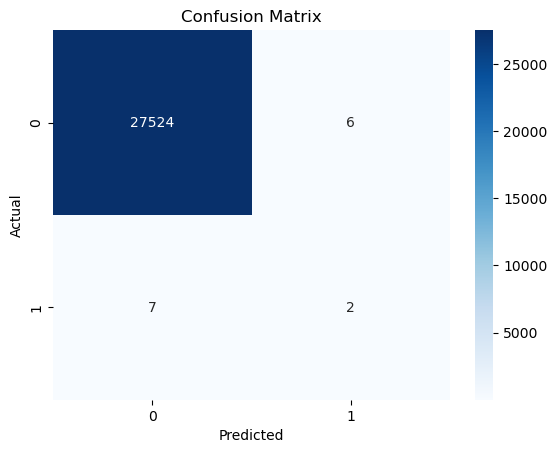

In [98]:
# Time-Based Features

streaming["time_diff_days"] = (streaming["event_time"] - streaming["install_time"]).dt.total_seconds() / (3600 * 24)
streaming["touch_to_install_time"] = (streaming["install_time"] - streaming["attributed_touch_time"]).dt.total_seconds() / 3600
streaming["session_hour"] = streaming["event_time"].dt.hour

# Content-Based Features
streaming["media_duration"] = streaming["event_value"].apply(lambda x: json.loads(x).get("media_duration", 0) if pd.notnull(x) else 0)
streaming["content_type"] = streaming["event_value"].apply(lambda x: json.loads(x).get("af_content_type", "unknown") if pd.notnull(x) else "unknown")
streaming["content_language"] = streaming["event_value"].apply(lambda x: json.loads(x).get("language", "unknown") if pd.notnull(x) else "unknown")

# User Engagement Features
streaming["event_count_per_user"] = streaming.groupby("appsflyer_id")["event_name"].transform("count")
streaming["unique_content_views"] = streaming.groupby("appsflyer_id")["event_value"].transform(lambda x: x.nunique())

# Encode Categorical Features
streaming = pd.get_dummies(streaming, columns=["content_type", "content_language", "media_source"], drop_first=True)

# Target Variable (Assuming 'af_subscribe' exists)
streaming["is_subscribed"] = streaming["event_name"].apply(lambda x: 1 if x == "af_subscribe" else 0)

# Features & Target
features = ["time_diff_days", "touch_to_install_time", "session_hour", "media_duration", 
            "event_count_per_user", "unique_content_views"] + \
           [col for col in streaming.columns if "content_type_" in col or "Media Source_" in col]

X = streaming[features]
y = streaming["is_subscribed"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [106]:
actual_vs_predicted = streaming.loc[
    (streaming.index.isin(X_test.index)) & (streaming["event_name"] == "af_subscribe"),
    ["event_name", "is_subscribed", "predicted_is_subscribed"]
]
actual_vs_predicted

,event_name,is_subscribed,predicted_is_subscribed
85512,af_subscribe,1,0.0
85514,af_subscribe,1,0.0
85515,af_subscribe,1,0.0
85522,af_subscribe,1,1.0
85525,af_subscribe,1,0.0
85526,af_subscribe,1,0.0
85539,af_subscribe,1,0.0
85540,af_subscribe,1,0.0
85546,af_subscribe,1,1.0
